In [1]:
#!/usr/bin/python
# Software License Agreement (BSD License)
#
# Copyright (c) 2013, Juergen Sturm, TUM
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#
#  * Redistributions of source code must retain the above copyright
#    notice, this list of conditions and the following disclaimer.
#  * Redistributions in binary form must reproduce the above
#    copyright notice, this list of conditions and the following
#    disclaimer in the documentation and/or other materials provided
#    with the distribution.
#  * Neither the name of TUM nor the names of its
#    contributors may be used to endorse or promote products derived
#    from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS
# FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE
# COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT,
# INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING,
# BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
# LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN
# ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.
#
# Requirements: 
# sudo apt-get install python-argparse

"""
This script computes the absolute trajectory error from the ground truth
trajectory and the estimated trajectory.
"""

import sys
import numpy
import argparse
import associate

def align(model,data):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    data -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)
    
    """
    numpy.set_printoptions(precision=3,suppress=True)
    model_zerocentered = model - model.mean(1)
    data_zerocentered = data - data.mean(1)
    
    W = numpy.zeros( (3,3) )
    for column in range(model.shape[1]):
        W += numpy.outer(model_zerocentered[:,column],data_zerocentered[:,column])
    U,d,Vh = numpy.linalg.linalg.svd(W.transpose())
    S = numpy.matrix(numpy.identity( 3 ))
    if(numpy.linalg.det(U) * numpy.linalg.det(Vh)<0):
        S[2,2] = -1
    rot = U*S*Vh
    trans = data.mean(1) - rot * model.mean(1)
    
    model_aligned = rot * model + trans
    alignment_error = model_aligned - data
    
    trans_error = numpy.sqrt(numpy.sum(numpy.multiply(alignment_error,alignment_error),0)).A[0]
        
    return rot,trans,trans_error

def plot_traj(ax,stamps,traj,style,color,label):
    """
    Plot a trajectory using matplotlib. 
    
    Input:
    ax -- the plot
    stamps -- time stamps (1xn)
    traj -- trajectory (3xn)
    style -- line style
    color -- line color
    label -- plot legend
    
    """
    stamps.sort()
    interval = numpy.median([s-t for s,t in zip(stamps[1:],stamps[:-1])])
    x = []
    y = []
    last = stamps[0]
    for i in range(len(stamps)):
        if stamps[i]-last < 2*interval:
            x.append(traj[i][0])
            y.append(traj[i][1])
        elif len(x)>0:
            ax.plot(x,y,style,color=color,label=label)
            label=""
            x=[]
            y=[]
        last= stamps[i]
    if len(x)>0:
        ax.plot(x,y,style,color=color,label=label)
            


In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.patches import Ellipse
%matplotlib inline

In [3]:
def calculate_traj(first_file, second_file):
    
    first_list = associate.read_file_list(first_file)
    second_list = associate.read_file_list(second_file)


    matches = associate.associate(first_list, second_list,float(offset),float(max_difference))    
    if len(matches)<2:
        sys.exit("Couldn't find matching timestamp pairs between groundtruth and estimated trajectory! Did you choose the correct sequence?")


    first_xyz = numpy.matrix([[float(value) for value in first_list[a][0:3]] for a,b in matches]).transpose()
    second_xyz = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for a,b in matches]).transpose()
    rot,trans,trans_error = align(second_xyz,first_xyz)

    second_xyz_aligned = rot * second_xyz + trans

    first_stamps = first_list.keys()
    first_stamps.sort()
    first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()

    second_stamps = second_list.keys()
    second_stamps.sort()
    second_xyz_full = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for b in second_stamps]).transpose()
    second_xyz_full_aligned = rot * second_xyz_full + trans
    error = numpy.sqrt(numpy.dot(trans_error,trans_error) / len(trans_error))
    return error, second_stamps, second_xyz_full_aligned

In [125]:
scale=1.0
offset=0
max_difference=0.02

first_file = "/mnt/d/VMware_share/Data/TUM/rgbd_dataset_freiburg3_walking_static/groundtruth.txt"
orb_file =  "/mnt/d/VMware_share/Experiments/trajectories/w_static_ORB.txt"
dyna_file = "/mnt/d/VMware_share/Experiments/trajectories/w_static_Dyna1.txt"

first_list = associate.read_file_list(first_file)
first_stamps = first_list.keys()
first_stamps.sort()
first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()


first_list = associate.read_file_list(first_file)
second_list = associate.read_file_list(dyna_file)

matches = associate.associate(first_list, second_list,float(offset),float(max_difference))    
if len(matches)<2:
    sys.exit("Couldn't find matching timestamp pairs between groundtruth and estimated trajectory! Did you choose the correct sequence?")


first_xyz = numpy.matrix([[float(value) for value in first_list[a][0:3]] for a,b in matches]).transpose()
second_xyz = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for a,b in matches]).transpose()
rot,trans,trans_error = align(second_xyz,first_xyz)

second_xyz_aligned = rot * second_xyz + trans

first_stamps = first_list.keys()
first_stamps.sort()
first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()

second_stamps = second_list.keys()
second_stamps.sort()
second_xyz_full = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for b in second_stamps]).transpose()
second_xyz_full_aligned = rot * second_xyz_full + trans

In [126]:
error_orb, time_orb, traj_orb = calculate_traj(first_file, orb_file)

In [127]:
error_dyna, time_dyna, traj_dyna = calculate_traj(first_file, dyna_file)

In [128]:
error_orb, error_dyna

(0.37886774311630056, 0.01611563688767199)

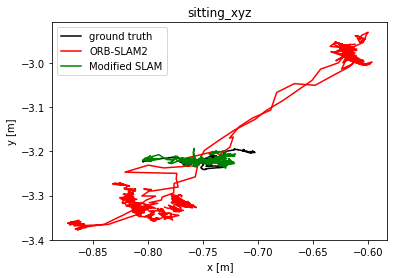

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_traj(ax,first_stamps,first_xyz_full.transpose().A,'-',"black","ground truth")
plot_traj(ax,time_orb,traj_orb.transpose().A,'-',"red","ORB-SLAM2")
plot_traj(ax,time_dyna,traj_dyna.transpose().A,'-',"green","Modified SLAM")


ax.legend()
ax.set_title("sitting_xyz")
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()
#plt.savefig(args.plot,dpi=90)

In [33]:
def calc_errors(ground_truth, filename):
    errors = []
    for i in range(5):
        error, _, _ = calculate_traj(ground_truth, filename.format(i))
        errors.append(error)
    return errors

In [119]:
ground_truth = "/mnt/d/VMware_share/Data/TUM/rgbd_dataset_freiburg3_walking_rpy/groundtruth.txt"
file_name = "/mnt/d/VMware_share/Experiments/trajectories/w_rpy_Dyna{}.txt"

In [120]:
errors = calc_errors(ground_truth, file_name)

In [121]:
print(errors)

[0.10662539552699381, 0.12300678746662759, 0.14861984359658514, 0.0704165025406468, 0.1513750157266809]


In [122]:
min(errors)

0.0704165025406468

In [123]:
max(errors)

0.1513750157266809

In [124]:
import numpy as np
np.median(errors)

0.12300678746662759